In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


In [2]:
def get_radar_field(radar):

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('reflectivity')
    # Mask reflectivity
    radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
    radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
        gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
    rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")
    radar.add_field('rainrate',rr,replace_existing=True)
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['rainrate']['data'][:, -10:] = np.ma.masked
    
    return radar,gatefilter

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#filepath = "../data/Radar/2017/01/08"
filepath = "../data/Radar/1996/02/01"

fnamelist = os.listdir(filepath)
fname = fnamelist[0]
radar = pyart.io.read(os.path.join(filepath,fname))
rad,gatefilter = get_radar_field(radar)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\pyart\io\nexrad_level2.py:169: UserWarning: No MSG5 detected. Setting to meaningless data. Rethink your life choices and be ready for errors.Specifically fixed angle data will be missing
  warnings.warn("No MSG5 detected. Setting to meaningless data. "
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\pyart\io\nexrad_archive.py:209: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


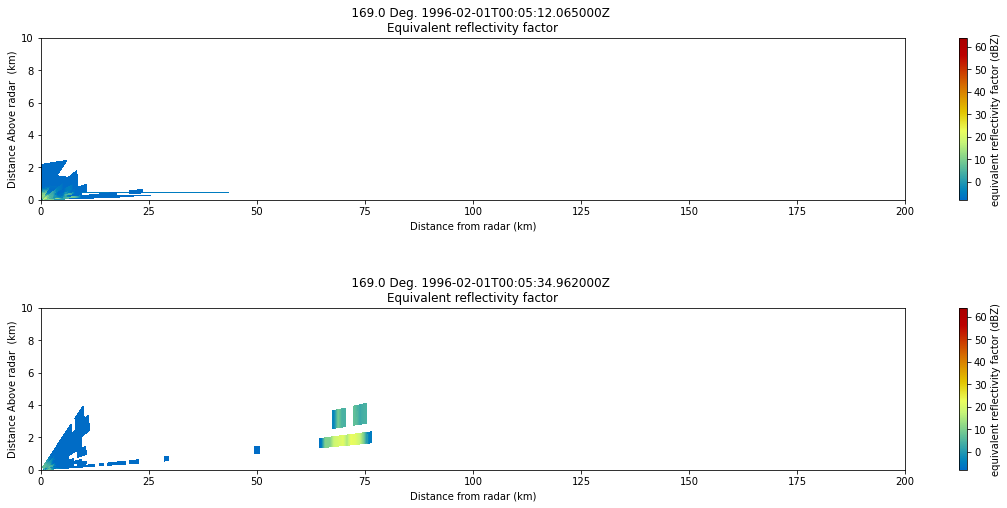

In [4]:
# Plotting
fig = plt.figure(figsize=[15,15])
rhi0_panel_axes = [0.05, 0.10, 1, .15]
rhi1_panel_axes = [0.05, 0.35, 1, .15]

# Set parameters.
vmin = -8
vmax = 64

xsect = pyart.util.cross_section_ppi(rad, [169,270.2])

# plotting RHI
display = pyart.graph.RadarDisplay(xsect)
ax3 = fig.add_axes(rhi0_panel_axes)
display.plot('reflectivity', 0, vmin=vmin, vmax=vmax)
ax4 = fig.add_axes(rhi1_panel_axes)
display.plot('reflectivity', 1, vmin=vmin, vmax=vmax)
for ax in [ax3,ax4]:
    ax.set_ylim((0,10))
    ax.set_xlim((0,200))
plt.tight_layout()

# get time info
timeobj = dt.datetime.strptime(rad.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')
dt.datetime.strftime(timeobj,'%Y%m%d_%H%M%S')

savefname_fig = '170az_270az_RHI_'+dt.datetime.strftime(timeobj,'%Y%m%d_%H%M%S')+'.png'

In [5]:
qvp = pyart.retrieve.quasi_vertical_profile(rad, fields='reflectivity', desired_angle=10.0, gatefilter=gatefilter)

[ 0.5  0.5  1.4  1.5  2.5  3.4  4.3  5.8 10.  14.6 19.5]
19.511719


C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
rad.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (4028,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (4028,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	velocity:
		data: <ndarray of type: float32 and shape: (4028, 1840)>
		units: meters_per_second
		standard_name: radial_velocity_of_scatterers_away_from_instrument
		long_name: Mean doppler Velocity
		valid_max: 95.0
		valid_min: -95.0
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	spectrum

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
rad_filtered = deepcopy(radar)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
az2 = np.tile(rad.azimuth['data'], (1840,1)).T

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
az_dict = {}
az_dict['data'] = az2
az_dict['units'] = rad.azimuth['units']
az_dict['standard_name'] = rad.azimuth['standard_name']
az_dict['long_name'] = rad.azimuth['long_name']
az_dict['axis'] = rad.azimuth['axis']
az_dict['comment'] = rad.azimuth['comment']

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
rad_filtered.add_field('azimuth2', az_dict)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
gatefilter = pyart.filters.GateFilter(rad_filtered)
gatefilter.include_inside('azimuth2',180,270)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
gatefilter

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


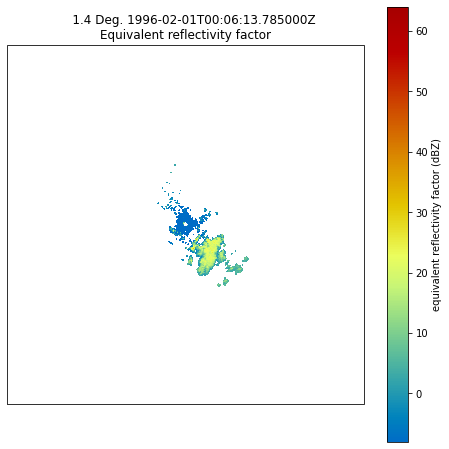

In [13]:
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(rad_filtered)
display.plot_ppi_map('reflectivity', sweep=2, resolution='50m',
                     vmin=-8, vmax=64, 
                     projection=ccrs.PlateCarree(),
                     gatefilter=gatefilter)

# LOOP

In [14]:
import pandas as pd

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
datafile = '../data/ARcatalog_NCEP_NEW_1948-2019.csv'

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
df = pd.read_csv(datafile)

year = 2017
df_ca = df.loc[(df.Lat > 35) & (df.Lat < 40) & (df.Year == year)]

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
ar_dates = []
year = 2017
for m in df_ca.Month.unique():
    df_ = df_ca.loc[(df_ca.Month == m)]
    df_start = df_.iloc[[0]]
    dstart = df_start.Day.get_values()[0]
    df_end = df_.iloc[[-1]]
    dend = df_end.Day.get_values()[0]
    start = dt.datetime(year,m,dstart)
    end = dt.datetime(year,m,dend)
    ar_dates.append([start,end])

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
ar_dates

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[datetime.datetime(2017, 1, 4, 0, 0), datetime.datetime(2017, 1, 22, 0, 0)],
 [datetime.datetime(2017, 2, 1, 0, 0), datetime.datetime(2017, 2, 21, 0, 0)],
 [datetime.datetime(2017, 3, 24, 0, 0), datetime.datetime(2017, 3, 30, 0, 0)],
 [datetime.datetime(2017, 4, 6, 0, 0), datetime.datetime(2017, 4, 27, 0, 0)],
 [datetime.datetime(2017, 5, 17, 0, 0), datetime.datetime(2017, 5, 17, 0, 0)],
 [datetime.datetime(2017, 9, 5, 0, 0), datetime.datetime(2017, 9, 21, 0, 0)],
 [datetime.datetime(2017, 10, 21, 0, 0),
  datetime.datetime(2017, 10, 21, 0, 0)],
 [datetime.datetime(2017, 11, 15, 0, 0),
  datetime.datetime(2017, 11, 24, 0, 0)]]

In [22]:
#d0 = dt.datetime(2017, 2,1)
#d1 = dt.datetime(2017, 2,16)
d0 = ar_dates[5][0]
d1 = ar_dates[5][1]
td = dt.timedelta(days = 1)
dates = np.arange(d0, d1, td).astype(dt.datetime)

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#filepath = "../data/Radar/2017/01/08"
for j in range(len(ar_dates))[5:]:
    print(j)
    d0 = ar_dates[j][0]
    d1 = ar_dates[j][1]
    td = dt.timedelta(days = 1)
    dates = np.arange(d0, d1, td).astype(dt.datetime)

    for d in dates:
        print(d)
        filepath = '../data/Radar/'+str(d.year)+'/'+str(d.month).zfill(2)+'/'+str(d.day).zfill(2)

        fnamelist = os.listdir(filepath)
        fname = fnamelist[0]
        radar = pyart.io.read(os.path.join(filepath,fname))
        rad,gatefilter = get_radar_field(radar)

        qvp_refl = []
        qvp_height = []
        qvp_time = []
        qvp_range = []

        fnamelist.sort()

        for fname in fnamelist:
            try:
                radar = pyart.io.read(os.path.join(filepath,fname))
            except:
                continue
            rad,gatefilter = get_radar_field(radar)

            qvp = pyart.retrieve.quasi_vertical_profile(rad, fields='reflectivity', desired_angle=10.0, gatefilter=gatefilter)
            timeobj = dt.datetime.strptime(qvp['time']['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')

            qvp_refl.append(qvp['reflectivity'].data)
            qvp_height.append(qvp['height'].data)
            qvp_time.append(timeobj)
            qvp_range.append(qvp['range'].data)    

        qvp_refl = np.array(qvp_refl)
        qvp_height = np.array(qvp_height)
        qvp_time = np.array(qvp_time)
        qvp_range = np.array(qvp_range)

        # create dictionary
        data = {}
        data['reflectivity'] = qvp_refl
        data['time'] = qvp_time
        data['height'] = qvp_height
        data['range'] = qvp_range

        savefname = 'qvp_10deg_'+str(timeobj.year)+str(timeobj.month).zfill(2)+str(timeobj.day).zfill(2)+'.hdf5'
        np.save(savefname, data)     

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5
2017-09-05 00:00:00
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.097656

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.35

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578 ]
1.7797852
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.31835

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531   12.480469   15.600586   19.511719  ]
19.35791
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531   12.480469  ]
12.370605
2017-09-12 00:00:00
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562 ]
5.0756836
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531  ]
9.953613
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531  ]
9.953613
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531  ]
9.953613
[

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156
 7.998047  ]
7.932129
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531   12.480469  ]
12.414551
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   3.9990234   5.0976562   6.4160156
  7.998047   10.019531  ]
9.953613
[ 0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3940

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.3500977
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.394043
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  3.9990234  5.0976562  6.4160156 ]
6.39404

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
2017-09-19 00:00:00
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.460449
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.48339844 0.48339844 1.4501953  1.4501953  2.4169922  3.3398438
 4.3066406  6.020508   9.887695  ]
9.876709
[0.4833984

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  0.48339844 0.48339844 3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.4

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   0.48339844  0.48339844  2.416

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[ 0.48339844

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   0.48339844  0.48339844  2.4169922   3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.409058
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.409058
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.409058
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.365112
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.41

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586  ]
15.4852295
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.31

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.396362
[ 0.48339844  0.48339844  0.87890625  0.8789

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[ 0.48339844  0.48339844  0.87890625  0.8789

[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   3.1201172   0.48339844  0.48339844  3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.409058
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.4833984

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.4

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.4833984

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  0.48339844  0.48339844  1.8017578   2.4169922   3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469   15.600586
 19.511719  ]
19.352417
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  3.1201172  0.48339844 0.48339844 3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  0.48339844 0.48339844 2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  0.48339844  0.48

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.483

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.4833984

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406  2.5048828  3.515625
 4.482422  ]
4.454956
[0.48339844 0.48339844 1.4941406  1.4941406

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.4833984

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  0.48339844  0.48339844  1.8017578   2.4169922   3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531   12.480469  ]
12.409058
[ 0.48339844  0.48339844  0.87890625  0.87890625  1.3183594   1.3183594
  1.8017578   2.4169922   0.48339844  0.48339844  3.1201172   3.9990234
  5.0976562   6.4160156   7.998047   10.019531  ]
9.94812
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.8017578  2.4169922  0.48339844 0.48339844 3.1201172  3.9990234
 5.0976562  6.4160156  7.998047  ]
7.9266357
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 1.801757

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.4833984

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.3446045
[0.48339844 0.48339844 0.87890625 0.87890625 1.3183594  1.3183594
 0.48339844 0.48339844 1.8017578  2.4169922  3.1201172  3.9990234
 5.0976562  6.4160156 ]
6.38855
[0.48339844 

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


(0.0, 10.0)

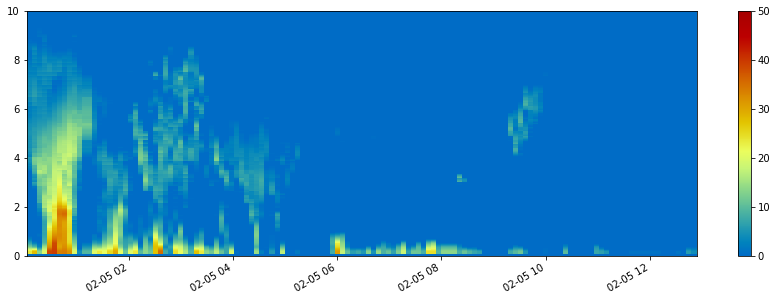

In [16]:
# Plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

qmesh = plt.pcolormesh(qvp_time, qvp_height[-1]/1000., qvp_refl.T, vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax = plt.gca()

fig.colorbar(qmesh,ax=ax)
ax.axis('tight')

# Set up as dates
ax.xaxis_date()
fig.autofmt_xdate()

ax.set_ylim((0,10))

Things to think about next:

* getting the QVP of a sector
* saving the QVP into a file
* generating multiple QVPs
